In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scipy.cluster.hierarchy as hc
import sys
sys.path
sys.path.append('./dave/diffimg/')
import tessprf as prf
from scipy import signal
from scipy import interpolate
from scipy.ndimage.filters import convolve
from scipy.signal import fftconvolve

In [4]:
def centroid(timespan, fluxarr, mask):
   # inputs: length of flux array, flux array (3 dimensional), aperture mask for centroiding over only target
    x_cent = np.zeros(timespan)
    y_cent = np.zeros(timespan)
    for i in range(timespan):
        xfsum = 0
        yfsum = 0
        fsum = 0
        temp = fluxarr[i,:]
        for index, val in np.ndenumerate(temp):
            if mask[index] == 3:
                xfsum += index[1] * temp[index]
                yfsum += index[0] * temp[index]
                fsum += temp[index]
            else:
                pass
        x_cent[i] = xfsum / fsum
        y_cent[i] = yfsum / fsum
    return x_cent, y_cent

def centroid_nomask(timespan, fluxarr):
    # inputs: length of flux array, flux array (3 dimensional), aperture mask for centroiding over only target
    x_cent = np.zeros(timespan)
    y_cent = np.zeros(timespan)
    for i in range(timespan):
        xfsum = 0
        yfsum = 0
        fsum = 0
        temp = fluxarr[i,:]
        for index, val in np.ndenumerate(temp):
            xfsum += index[1] * temp[index]
            yfsum += index[0] * temp[index]
            fsum += temp[index]
        x_cent[i] = xfsum / fsum
        y_cent[i] = yfsum / fsum
    return x_cent, y_cent

In [4]:
tess = np.load('tess.npy')
ps1_full = np.load('PS1.npy')
ps1 = ps1_full[0]
ps1_re = np.load('PS1_regrid.npy')

<IPython.core.display.Javascript object>


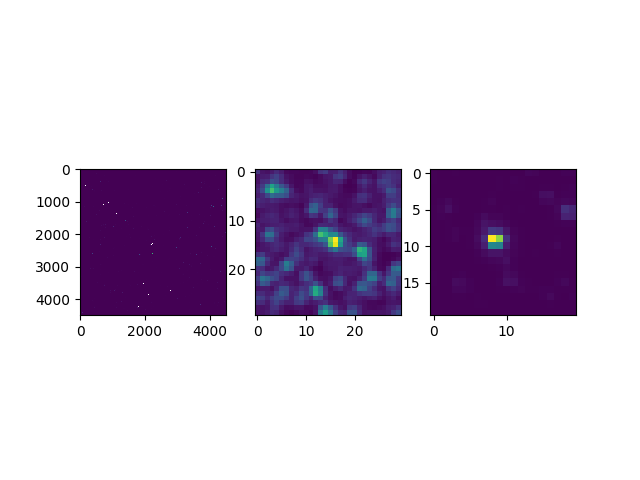

In [118]:
%matplotlib notebook

fig, ax = plt.subplots(1,3)
ax[0].imshow(ps1)
ax[1].imshow(ps1_re)
ax[2].imshow(tess)

In [5]:
sources_x = np.zeros(0)
sources_y = np.zeros(0)
sourcemask = np.zeros(ps1.shape)
ps1_range = np.nanmax(ps1) - np.nanmin(ps1)
range_cut = ps1_range * 0.95

# %matplotlib notebook
# plt.imshow(ps1)

for index, val in np.ndenumerate(ps1):
    if np.isnan(val) == True or val>range_cut:
#         plt.plot(index[1], index[0], 'r*')
        sources_x = np.append(sources_x, index[1])
        sources_y = np.append(sources_y, index[0])
#         sourcemask[index] += 1

In [6]:
sources = np.c_[sources_x, sources_y]
clusters = hc.fclusterdata(sources, 1, criterion="distance")

<IPython.core.display.Javascript object>


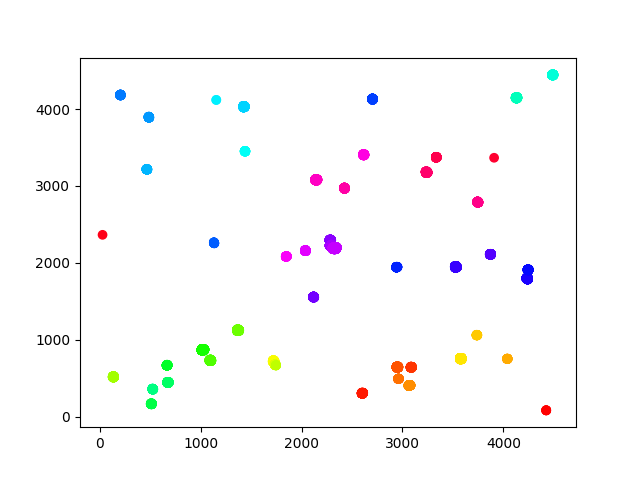

In [7]:
%matplotlib notebook

plt.scatter(sources_y, sources_x, c=clusters, cmap='hsv')

In [31]:
source_img = np.zeros(ps1.shape)
for i, val in enumerate(clusters):
    source_img[int(sources_y[i]), int(sources_x[i])] += val
    
# %matplotlib notebook
# cmap = plt.cm.hsv
# cmap.set_under(color='white')
# plt.imshow(source_img, cmap=cmap, vmin=0.00001)

<IPython.core.display.Javascript object>


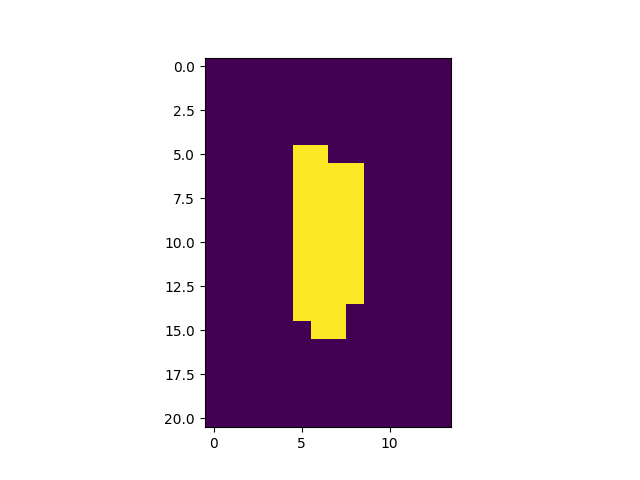

In [65]:
# clusters: 1 - 53
cluster = 5
box = np.argwhere(source_img==cluster)
expand = 5
max_x = max(box[:,1])+expand+1
min_x = min(box[:,1])-expand
max_y = max(box[:,0])+expand+1
min_y = min(box[:,0])-expand
cutout = source_img[min_y:max_y,min_x:max_x]
for i, val in np.ndenumerate(cutout):
    if val != cluster:
        cutout[i] = 0

%matplotlib notebook
plt.imshow(cutout)

In [39]:
def Interp_PRF(X,Y,Camera,CCD):
    pathToMatFile = './data/prf/'
    obj = prf.TessPrf(pathToMatFile)
    PRF = obj.getPrfAtColRow(123.0, 456, 1,Camera,CCD)
    x2 = np.arange(0,PRF.shape[1]-1,0.01075)
    y2 = np.arange(0,PRF.shape[0]-1,0.01075)

    x = np.arange(0,PRF.shape[1],1)
    y = np.arange(0,PRF.shape[0],1)
    X, Y = np.meshgrid(x,y)

    x=X.ravel()              #Flat input into 1d vector
    y=Y.ravel()

    z = PRF
    z = z.ravel()
    x = list(x[np.isfinite(z)])
    y = list(y[np.isfinite(z)])
    z = list(z[np.isfinite(z)])

    znew = interpolate.griddata((x, y), z, (x2[None,:], y2[:,None]), method='cubic')
    kernal = znew
    return kernal

In [66]:
kernel = Interp_PRF(100,200,1,2)
bool_cutout = np.zeros(cutout.shape)
for i, val in np.ndenumerate(cutout):
    if val != 0:
        bool_cutout[i] += 1
test = fftconvolve(bool_cutout,kernel)

<IPython.core.display.Javascript object>


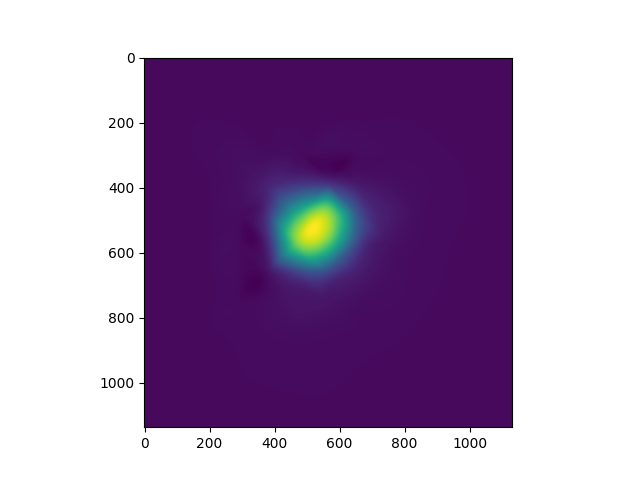

In [67]:
%matplotlib notebook
plt.imshow(test)